In [ ]:
IMAGE_SIZE = 32
CHANNELS = 1
BATCH_SIZE = 100
BUFFER_SIZE = 1000
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 3

In [ ]:
from tensorflow.keras import datasets
(x_train,y_train), (x_test,y_test) = datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


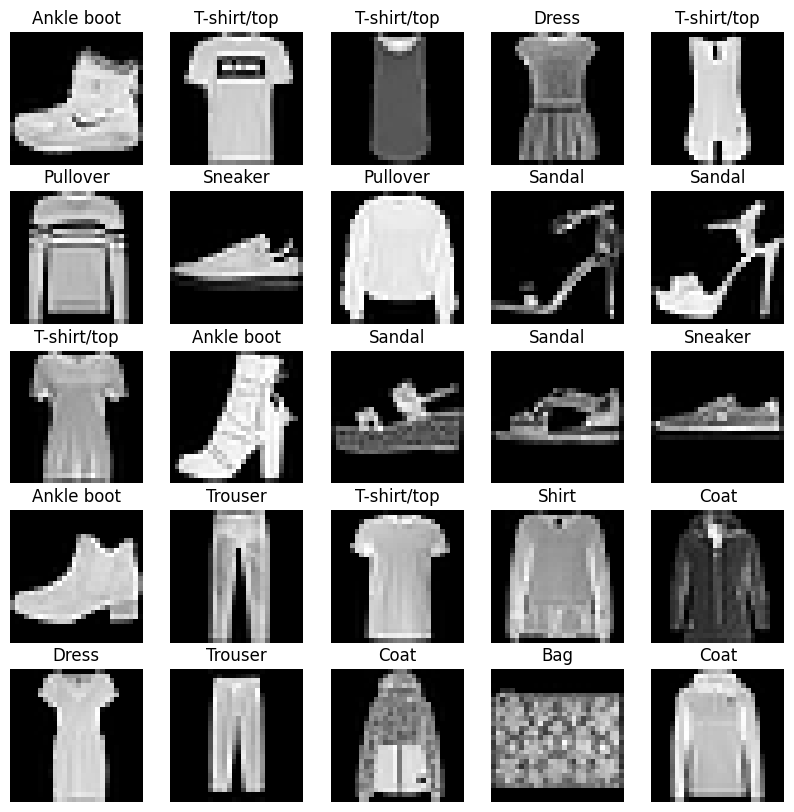

In [ ]:
import matplotlib.pyplot as plt
# Define the class names for better visualization
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# Display some sample images
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(class_names[y_train[i]])
    plt.axis('off')

plt.show()

These are 28 × 28 grayscale images (pixel values between 0 and 255) out of the box,
which we need to preprocess to ensure that the pixel values are scaled between 0 and 1.

 We will also pad each image to 32 × 32 for easier manipulation of the tensor shape
as it passes through the network

In [ ]:
import numpy as np

def preprocess(imgs):
 imgs = imgs.astype("float32") / 255.0
 imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
 imgs = np.expand_dims(imgs, -1)
 return imgs
x_train = preprocess(x_train)
x_test = preprocess(x_test)

# The Autoencoder Architecture

An autoencoder is a neural network made up of two parts:
• An encoder network that compresses high-dimensional input data such as an
image into a lower-dimensional embedding vector


• A decoder network that decompresses a given embedding vector back to the orig‐
inal domain (e.g., back to an image)


In our example, we will embed images into a two-dimensional latent space. This will
help us to visualize the latent space, since we can easily plot points in 2D. In practice,
the latent space of an autoencoder will usually have more than two dimensions in
order to have more freedom to capture greater nuance in the images.


Autoencoders as Denoising Models


Autoencoders can be used to clean noisy images, since the encoder
learns that it is not useful to capture the position of the random
noise inside the latent space in order to reconstruct the original.

In [ ]:
from tensorflow.keras import layers
from keras import backend as K
from keras import models

In [ ]:
encoder_input = layers.Input(shape=(32, 32, 1), name = "encoder_input")
x = layers.Conv2D(32, (3, 3), strides = 2, activation = 'relu', padding="same")(encoder_input)
x = layers.Conv2D(64, (3, 3), strides = 2, activation = 'relu', padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides = 2, activation = 'relu', padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]
x = layers.Flatten()(x)
encoder_output = layers.Dense(2, name="encoder_output")(x)
encoder = models.Model(encoder_input, encoder_output)

 The last convolutional layer is flattened and connected to a
Dense layer of size 2, which represents our two-dimensional latent space.

In [ ]:
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 32)        320       
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 encoder_output (Dense)      (None, 2)                 4098      
                                                                 
Total params: 96770 (378.01 KB)
Trainable params: 96770 (378.

In [ ]:
decoder_input = layers.Input(shape=(2,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation = 'relu', padding="same")(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation = 'relu', padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation = 'relu', padding="same")(x)
decoder_output = layers.Conv2D(1,(3, 3), strides = 1, activation="sigmoid", padding="same", name="decoder_output")(x)
decoder = models.Model(decoder_input, decoder_output)

In [ ]:
decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 2048)              6144      
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 128)         147584    
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 16, 16, 64)        73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 32, 32, 32)        1846

To train the encoder and decoder simultaneously, we need to define a model that will
represent the flow of an image through the encoder and back out through the
decoder

In [ ]:
from keras.models import Model
autoencoder = Model(encoder_input, decoder(encoder_output))

The Keras Model that defines the full autoencoder—a model that takes an image
and passes it through the encoder and back out through the decoder to generate
a reconstruction of the original image.

The loss function is usually chosen to be either
the root mean squared error (RMSE) or binary cross-entropy between the individual
pixels of the original image and the reconstruction.

In [ ]:
# Compile the autoencoder
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

Optimizing for RMSE means that your generated output will be symmetrically dis‐
tributed around the average pixel values (because an overestimation is penalized
equivalently to an underestimation).


On the other hand, binary cross-entropy loss is asymmetrical—it penalizes errors
toward the extremes more heavily than errors toward the center. For example, if the
true pixel value is high (say 0.7), then generating a pixel with value 0.8 is penalized
more heavily than generating a pixel with value 0.6. If the true pixel value is low (say
0.3), then generating a pixel with value 0.2 is penalized more heavily than generating
a pixel with value 0.4.


This has the effect of binary cross-entropy loss producing slightly blurrier images
than RMSE loss (as it tends to push predictions toward 0.5), but sometimes this is
desirable as RMSE can lead to obviously pixelized edges.
There is no right or wrong choice—you should choose whichever works best for your
use case after experimentation.


In [ ]:
autoencoder.fit(
 x_train,
 x_train,
 epochs=10,
 batch_size=100,
 shuffle=True,
 validation_data=(x_test, x_test),
)

Epoch 1/10
600/600 [==============================] - 14s 10ms/step - loss: 0.2994 - val_loss: 0.2629
Epoch 2/10
600/600 [==============================] - 6s 10ms/step - loss: 0.2591 - val_loss: 0.2576
Epoch 3/10
600/600 [==============================] - 6s 10ms/step - loss: 0.2552 - val_loss: 0.2552
Epoch 4/10
600/600 [==============================] - 7s 12ms/step - loss: 0.2531 - val_loss: 0.2539
Epoch 5/10
600/600 [==============================] - 6s 10ms/step - loss: 0.2517 - val_loss: 0.2525
Epoch 6/10
600/600 [==============================] - 7s 12ms/step - loss: 0.2504 - val_loss: 0.2519
Epoch 7/10
600/600 [==============================] - 6s 10ms/step - loss: 0.2496 - val_loss: 0.2508
Epoch 8/10
600/600 [==============================] - 6s 10ms/step - loss: 0.2489 - val_loss: 0.2500
Epoch 9/10
600/600 [==============================] - 6s 10ms/step - loss: 0.2482 - val_loss: 0.2501
Epoch 10/10
600/600 [==============================] - 6s 10ms/step - loss: 0.2476 - val_l

We can test the ability to reconstruct images by passing images from the test set
through the autoencoder and comparing the output to the original images.

In [ ]:
example_images = x_test[:5000]
predictions = autoencoder.predict(example_images)

157/157 [==============================] - 1s 3ms/step


1/1 [==============================] - 0s 27ms/step


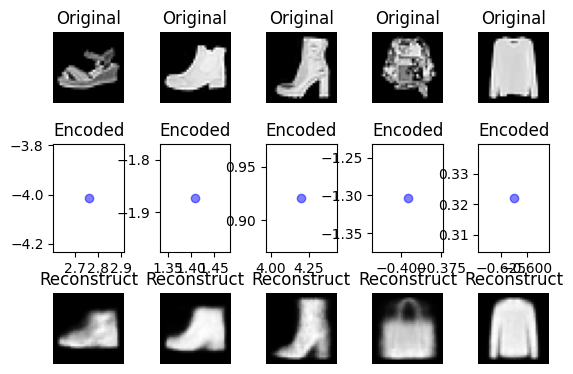

In [ ]:
# Assuming example_images and predictions are already defined
num_images = 5
random_indices = np.random.choice(len(example_images), num_images)

# Get the shape of the images
img_shape = example_images.shape[1:]

# Set the spacing between subplots
plt.subplots_adjust(wspace=0.5)

# Plot original, encoded vectors, and reconstructed images
for i, idx in enumerate(random_indices):
    # Original image
    plt.subplot(3, num_images, i + 1)
    plt.imshow(example_images[idx].reshape(img_shape), cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # Encoded vector
    plt.subplot(3, num_images, num_images + i + 1)
    encoded_vector = encoder.predict(example_images[idx][np.newaxis, ...])
    plt.scatter(encoded_vector[:, 0], encoded_vector[:, 1], c='blue', alpha=0.5)
    plt.title('Encoded')

    # Reconstructed image
    plt.subplot(3, num_images, 2 * num_images + i + 1)
    reconstructed_image = autoencoder.predict(example_images[idx][np.newaxis, ...])
    plt.imshow(reconstructed_image.reshape(img_shape), cmap='gray')
    plt.title('Reconstruct')
    plt.axis('off')

plt.show()

Notice how the reconstruction isn’t perfect—there are still some details of the original
images that aren’t captured by the decoding process, such as logos. This is becau

# Visualizing the Latent Space

We can visualize how images are embedded into the latent space by passing the test
set through the encoder and plotting the resulting embeddings

157/157 [==============================] - 0s 2ms/step


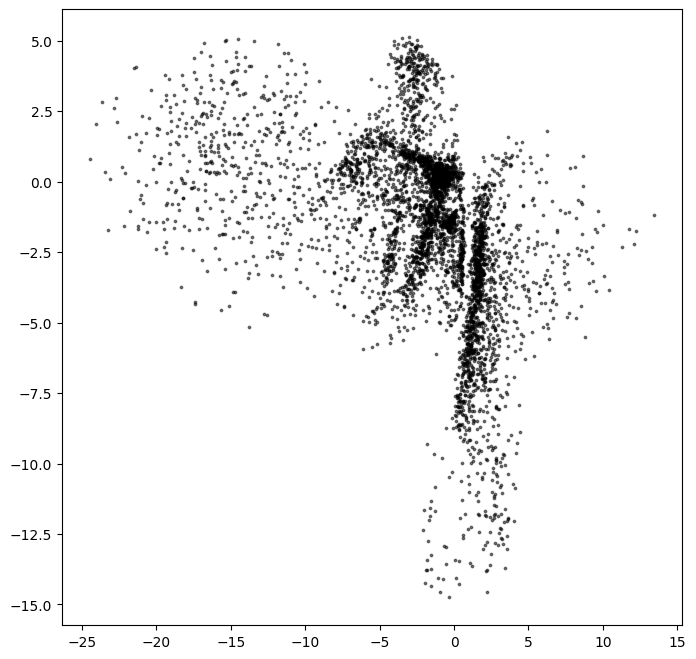

In [ ]:
embeddings = encoder.predict(example_images)
plt.figure(figsize=(8, 8))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=3)
plt.show()

The resulting plot is the scatter plot shown in each black point represents
an image that has been embedded into the latent space.


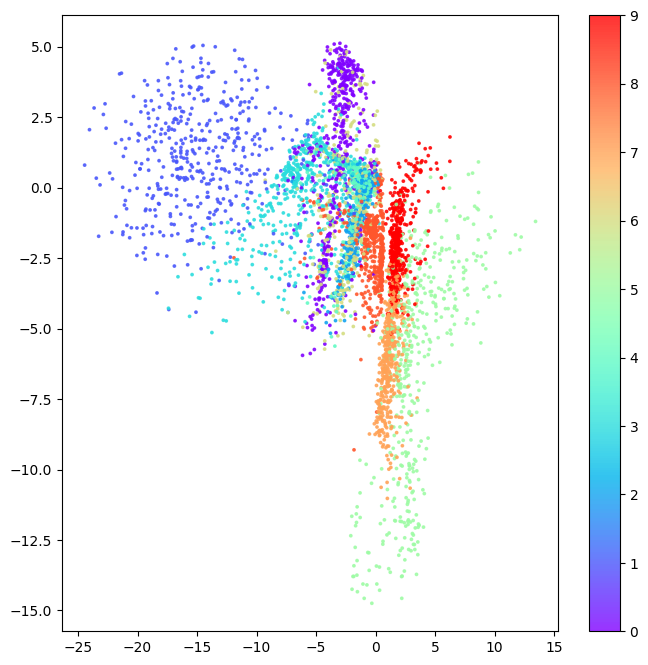

In [ ]:
# Colour the embeddings by their label (clothing type - see table)
example_labels = y_test[:5000]

figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=3,
)
plt.colorbar()
plt.show()

In order to better understand how this latent space is structured, we can make use of
the labels that come with the Fashion-MNIST dataset, describing the type of item in
each image. There are 10 groups altogether. We can color each point based on the label of the corresponding image to produce
the plot

! Even though the cloth‐
ing labels were never shown to the model during training, the autoencoder has natu‐
rally grouped items that look alike into the same parts of the latent space. For
example, the dark blue cloud of points in the bottom-right corner of the latent space
are all different images of trousers and the red cloud of points toward the center are
all ankle boots.

# Generating New Images

We can generate novel images by sampling some points in the latent space and using
the decoder to convert these back into pixel space

In [ ]:
# Get the range of the existing embeddings
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)

# Sample some points in the latent space
grid_width, grid_height = (6, 3)
sample = np.random.uniform(
    mins, maxs, size=(grid_width * grid_height, 2)
)

In [ ]:
# Decode the sampled points
reconstructions = decoder.predict(sample)

1/1 [==============================] - 0s 394ms/step


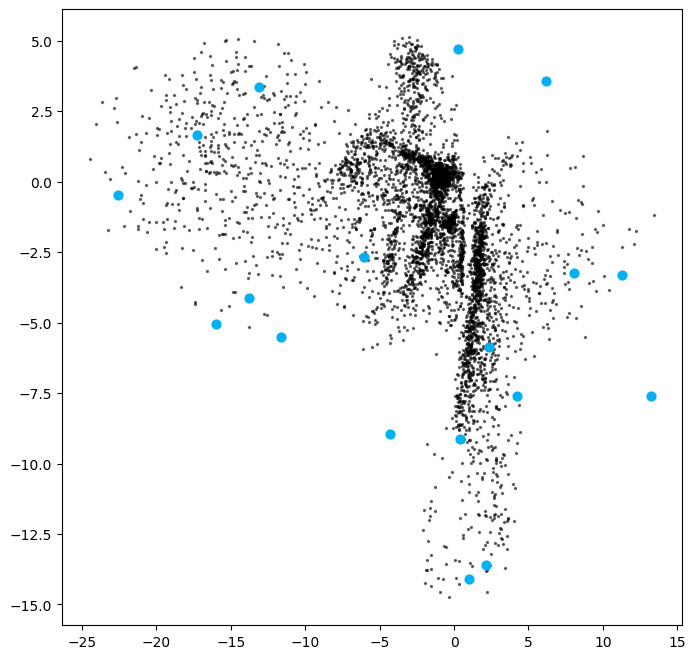

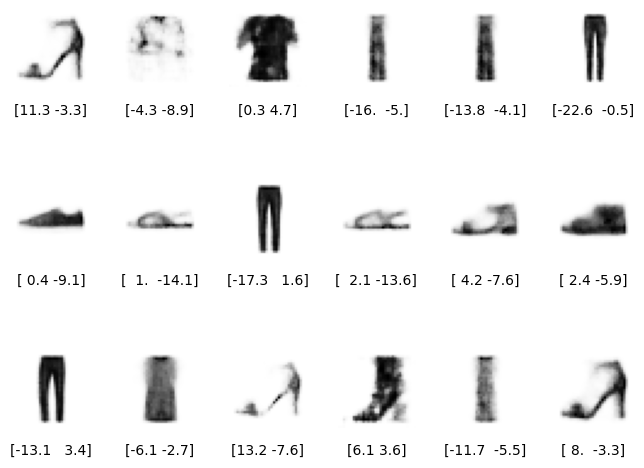

In [ ]:
# Draw a plot of...
figsize = 8
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="black", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(sample[:, 0], sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

Each blue dot maps to one of the images shown on the right of the diagram, with the
embedding vector shown underneath. Notice how some of the generated items are
more realistic than others. Why is this?


To answer this, let’s first make a few observations about the overall distribution of
points in the latent space, referring back to colored one:

• Some clothing items are represented over a very small area and others over a
much larger area.

• The distribution is not symmetrical about the point (0, 0), or bounded. For
example, there are far more points with negative y-axis values than positive, and
some points even extend to a y-axis value > -8.

• There are large gaps between colors containing few points.

These observations actually make sampling from the latent space quite challenging

8/8 [==============================] - 0s 3ms/step


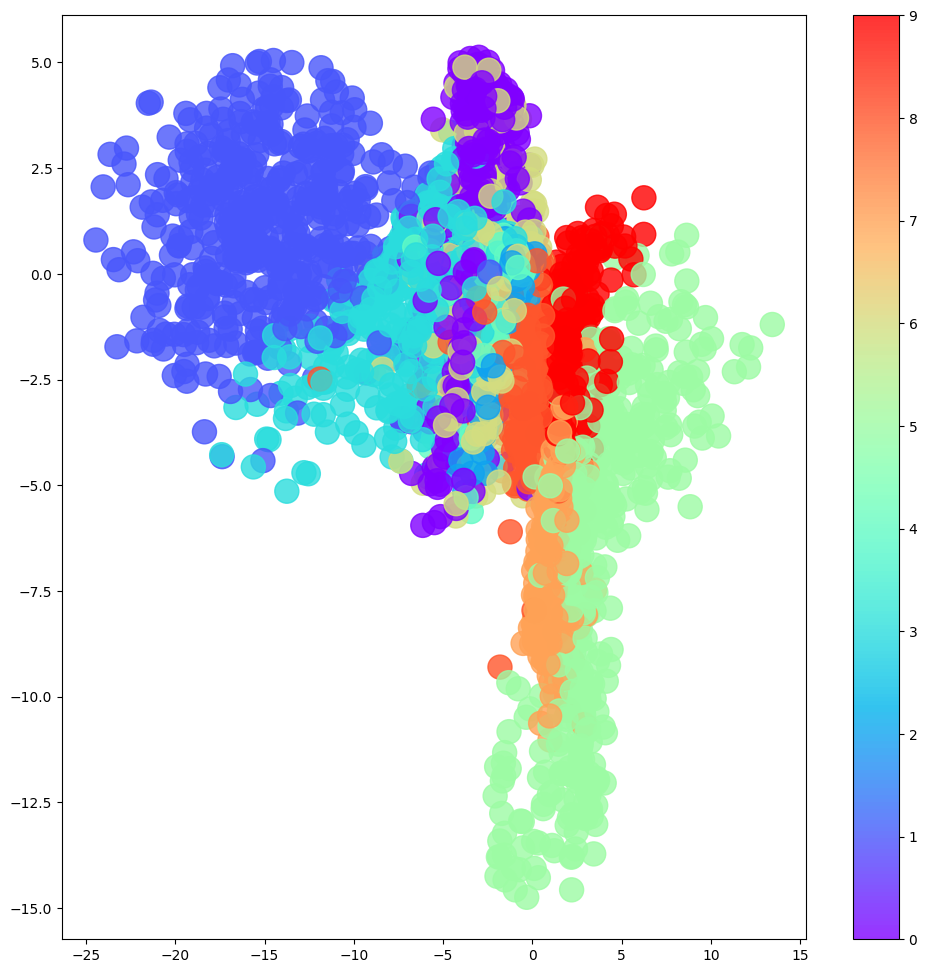

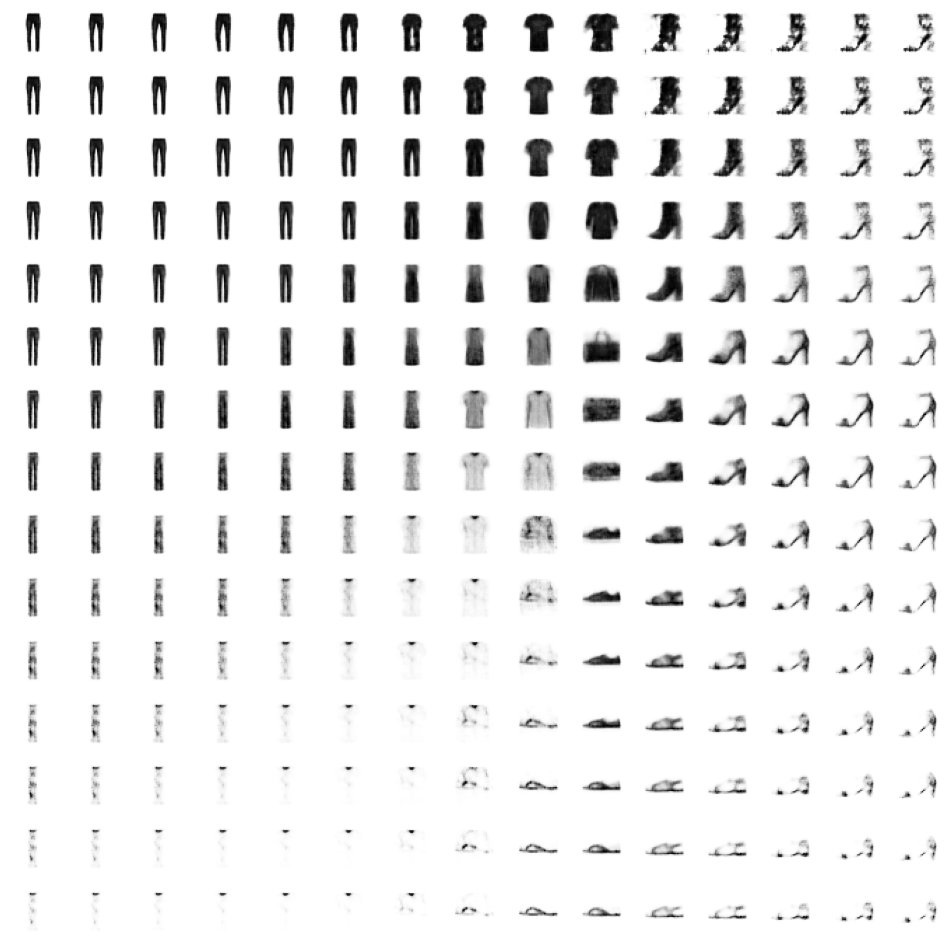

In [ ]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=300,
)
plt.colorbar()

x = np.linspace(min(embeddings[:, 0]), max(embeddings[:, 0]), grid_size)
y = np.linspace(max(embeddings[:, 1]), min(embeddings[:, 1]), grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

Firstly, we can see that if we pick points uniformly in a bounded space that we define,
we’re more likely to sample something that decodes to look like a bag (ID 8) than an
ankle boot (ID 9) because the part of the latent space carved out for bags (orange) is
larger than the ankle boot area (red).

Secondly, it is not obvious how we should go about choosing a random point in the
latent space, since the distribution of these points is undefined. Technically, we would
be justified in choosing any point in the 2D plane! It’s not even guaranteed that points
will be centered around (0, 0). This makes sampling from our latent space
problematic.

Lastly, we can see holes in the latent space where none of the original images are
encoded. For example, there are large white spaces at the edges of the domain—the
autoencoder has no reason to ensure that points here are decoded to recognizable
clothing items as very few images in the training set are encoded here.


Even points that are central may not be decoded into well-formed images. This is
because the autoencoder is not forced to ensure that the space is continuous

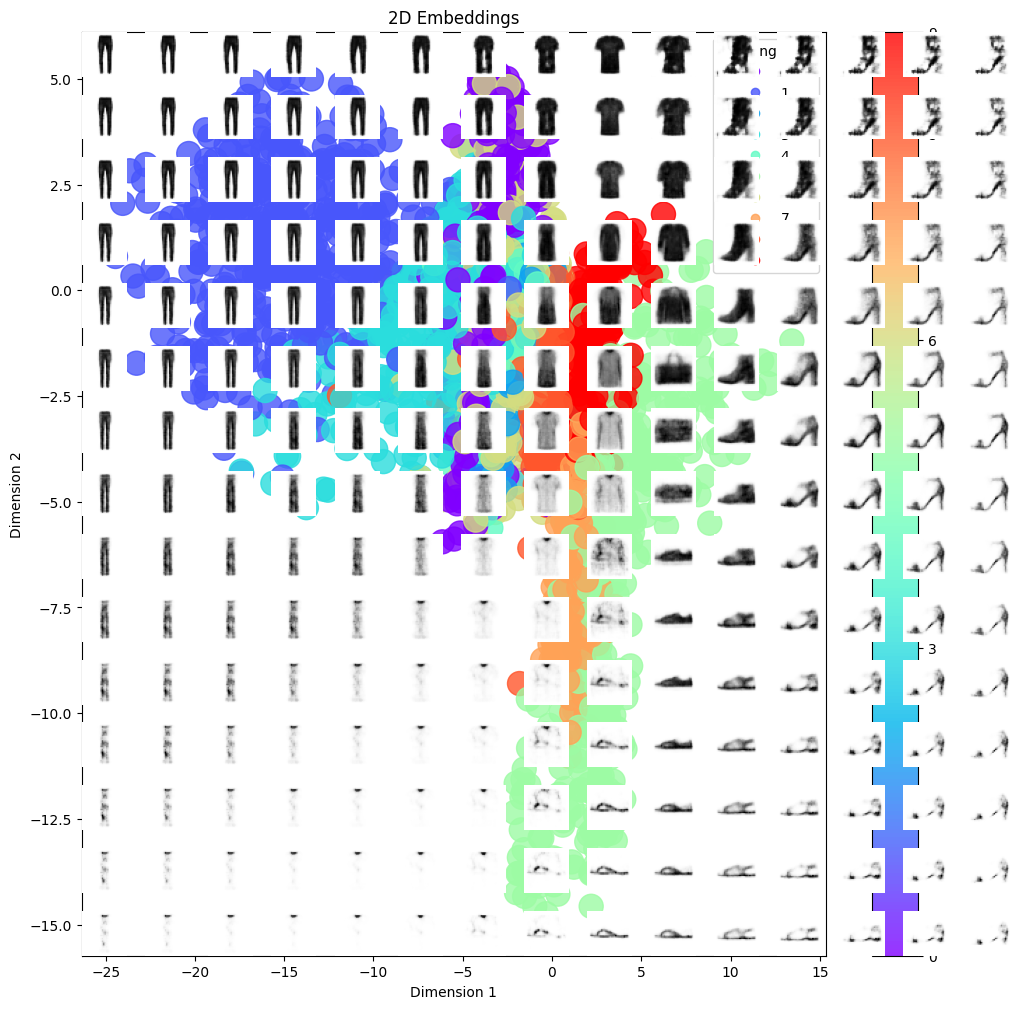

In [ ]:
# Scatter plot
fig, ax1 = plt.subplots(figsize=(figsize, figsize))
scatter = ax1.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=300,
)
ax1.set_title("2D Embeddings")
ax1.set_xlabel("Dimension 1")
ax1.set_ylabel("Dimension 2")
ax1.legend(*scatter.legend_elements(), title="Clothing Type")
plt.colorbar(scatter, ax=ax1)

# Image reconstructions
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

plt.show()

In two dimensions this issue is subtle; the autoencoder only has a small number of
dimensions to work with, so naturally it has to squash clothing groups together,
resulting in the space between clothing groups being relatively small. However, as we
start to use more dimensions in the latent space to generate more complex images
such as faces, this problem becomes even more apparent. If we give the autoencoder
free rein over how it uses the latent space to encode images, there will be huge gaps
between groups of similar points with no incentive for the spaces in between to gen‐
erate well-formed images.


In order to solve these three problems, we need to convert our autoencoder into a
variational autoencoder